In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
import joblib
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
df_1 = pd.read_csv("train.csv", index_col="Id")
df_2 = pd.read_csv("test.csv", index_col="Id")

In [3]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [4]:
df = pd.concat([df_1, df_2])
df.shape

(2919, 80)

In [5]:
# large percentage data missing
df.drop(["Alley","MiscFeature" ,"PoolQC","Fence","FireplaceQu", "YrSold", "MoSold"], axis = 1, inplace = True)  

In [6]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set a correlation threshold
correlation_threshold = 0.8

# Find highly correlated variable pairs
highly_correlated = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            highly_correlated.append(pair)

# Print the highly correlated pairs
print("Highly correlated variable pairs:")
for pair in highly_correlated:
    print(pair)

Highly correlated variable pairs:
('1stFlrSF', 'TotalBsmtSF')
('TotRmsAbvGrd', 'GrLivArea')
('GarageYrBlt', 'YearBuilt')
('GarageArea', 'GarageCars')


C:\Users\DELL\AppData\Local\Temp\ipykernel_7044\3835435189.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


In [7]:
# Drop one variable from each highly correlated pair
variables_to_drop = set()
for pair in highly_correlated:
    variables_to_drop.add(pair[1])  # Drop the second variable in the pair

In [8]:
df = df.drop(columns=variables_to_drop, axis = 1)

In [9]:
df.shape

(2919, 69)

C:\Users\DELL\AppData\Local\Temp\ipykernel_7044\1170764735.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


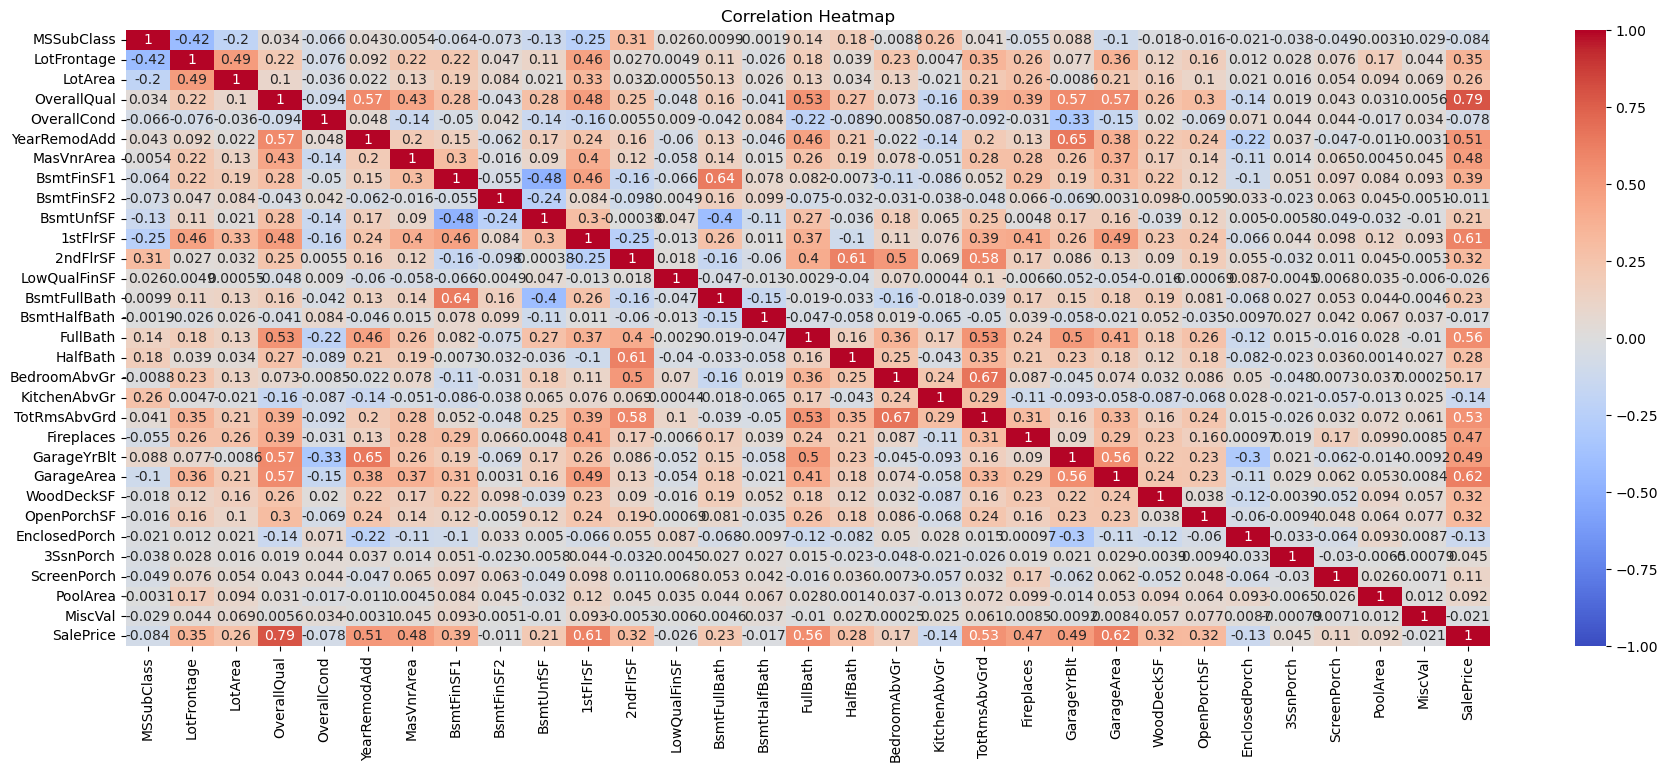

In [10]:
correlation_matrix = df.corr()

# Create a correlation heatmap using seaborn
plt.figure(figsize=(22, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [11]:
# function for selecting categorical columns 
def get_object_columns(df):
    object_columns = []

    for column in df.columns:
        if df[column].dtype == 'object':
            object_columns.append(column)

    return object_columns

In [12]:
categorical_columns = get_object_columns(df)
len(categorical_columns)

38

### fill missing values

In [13]:
imputer = SimpleImputer(strategy='most_frequent')
imputer1 = SimpleImputer(strategy='mean')

In [14]:
# Fill missing values in categorical columns
for column_name in categorical_columns:
    df[column_name] = imputer.fit_transform(df[[column_name]])

In [15]:
# numerical variables
for column_name in df.columns:
    if column_name not in categorical_columns and column_name != "SalePrice":
        df[column_name] = imputer1.fit_transform(df[[column_name]])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 69 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   float64
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   float64
 4   Street         2919 non-null   object 
 5   LotShape       2919 non-null   object 
 6   LandContour    2919 non-null   object 
 7   Utilities      2919 non-null   object 
 8   LotConfig      2919 non-null   object 
 9   LandSlope      2919 non-null   object 
 10  Neighborhood   2919 non-null   object 
 11  Condition1     2919 non-null   object 
 12  Condition2     2919 non-null   object 
 13  BldgType       2919 non-null   object 
 14  HouseStyle     2919 non-null   object 
 15  OverallQual    2919 non-null   float64
 16  OverallCond    2919 non-null   float64
 17  YearRemodAdd   2919 non-null   float64
 18  RoofStyl

### encoding

In [17]:
def one_hot_encode_and_concat(df, column_name):
    # Perform one-hot encoding
    encoded_columns = pd.get_dummies(df[column_name], prefix=column_name)
    
    # Drop the original categorical column
    df.drop([column_name], axis=1, inplace=True)
    
    # Concatenate the one-hot encoded columns to the original DataFrame
    df = pd.concat([df, encoded_columns], axis=1)
    
    return df

In [18]:
# Apply the function to each categorical column
for column_name in categorical_columns:
    df = one_hot_encode_and_concat(df, column_name)

In [19]:
df = df.loc[:, ~df.columns.duplicated()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Columns: 265 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(31), uint8(234)
memory usage: 1.4 MB


In [20]:
df = df.drop_duplicates()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Columns: 265 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(31), uint8(234)
memory usage: 1.4 MB


In [22]:
# df.to_csv("preprocessed_data.csv")

In [23]:
df1 = df.copy()

### outliers

In [24]:
for column in df1.columns:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
        
    df[column] = df[column].apply(lambda x: df[column].mean() if x < lower_bound or x > upper_bound else x)

In [25]:
df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60.000000,65.000000,8450.00000,7.0,5.000000,2003.0,196.0,706.0,0.0,150.0,...,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.000000,0.0
2,20.000000,80.000000,9600.00000,6.0,5.564577,1976.0,0.0,978.0,0.0,284.0,...,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.000000,0.0
3,60.000000,68.000000,11250.00000,7.0,5.000000,2002.0,162.0,486.0,0.0,434.0,...,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.000000,0.0
4,70.000000,60.000000,9550.00000,7.0,5.000000,1970.0,0.0,216.0,0.0,540.0,...,0.0,0.0,0.0,1.0,0.065091,0.0,0.0,0.0,0.822885,0.0
5,60.000000,84.000000,14260.00000,8.0,5.000000,2000.0,350.0,655.0,0.0,490.0,...,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,57.137718,69.305795,1936.00000,4.0,7.000000,1970.0,0.0,0.0,0.0,546.0,...,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.000000,0.0
2916,57.137718,69.305795,1894.00000,4.0,5.000000,1970.0,0.0,252.0,0.0,294.0,...,0.0,0.0,0.0,1.0,0.065091,0.0,0.0,0.0,0.822885,0.0
2917,20.000000,69.305795,10168.11408,5.0,7.000000,1996.0,0.0,1224.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.065091,0.0,0.0,0.0,0.822885,0.0


### data split

In [26]:
df_train = df.iloc[:len(df_1),:]
df_test = df.iloc[len(df_1):,:]

In [27]:
x_train = df_train.drop("SalePrice", axis = 1)
y_train = pd.DataFrame(data = df_train["SalePrice"], columns = ["SalePrice"],index = df_train.index)
x_test = df_test.drop("SalePrice", axis = 1)

### scaling 

In [28]:
scaler = MinMaxScaler()

In [29]:
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
y_train_scaled = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = y_train.columns)
x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test), columns = x_test.columns)

In [30]:
x1, x2, y1, y2 =  train_test_split(x_train_scaled, y_train_scaled, test_size=0.2, random_state=1)

## 1

In [31]:
# ridge, rf, XGB, catboost, Svr 
models = {
    "Ridge": Ridge(random_state=1),
    "Random Forest": RandomForestRegressor(random_state=1),
    "Adaboost" : AdaBoostRegressor(random_state=1),
    "XGBoost": GradientBoostingRegressor(random_state=1),
    "SVR": SVR()
}

# Loop through the models, fit them, and print R2 scores
for model_name, model in models.items():
    model.fit(x1, y1)
    y_pred = model.predict(x2)
    r2 = r2_score(y2, y_pred)
    print(f"R2 score for {model_name}: {r2:.4f}")

R2 score for Ridge: 0.7551


C:\Users\DELL\AppData\Local\Temp\ipykernel_7044\710837460.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x1, y1)


R2 score for Random Forest: 0.7820


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 score for Adaboost: 0.6938


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 score for XGBoost: 0.7689
R2 score for SVR: 0.7372


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Random Forest Regressor

In [38]:
param_rf = {
    'n_estimators': [900,1200],
    'max_depth': [None,5, 10, 15],
    'min_samples_split': [ 3,5,7],
    'min_samples_leaf': [2, 4,6 ],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [49]:
rf = joblib.load('rf.pkl')

In [39]:
# Create a Random Forest regressor
rfr = RandomForestRegressor(random_state=42,)

# Create the RandomizedSearchCV object
rf = RandomizedSearchCV(rfr, param_distributions=param_rf, n_iter=100, cv=5, n_jobs=-1, random_state=42,)

# Fit the RandomizedSearchCV on your data
rf.fit(x_train_scaled, y_train_scaled)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 4, 6],
                                        'min_samples_split': [3, 5, 7],
                                        'n_estimators': [900, 1200]},
                   random_state=42)

In [40]:
# Get the best parameters and best score
best_params_rf = rf.best_params_
best_score_rf = rf.best_score_

print("Best Parameters:", best_params_rf)
print("Best Score:", best_score_rf)

Best Parameters: {'n_estimators': 1200, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 15}
Best Score: 0.7667984241725483


In [50]:
pred_train_rf = rf.predict(x_train_scaled)
r2_rf = r2_score(y_train_scaled, pred_train_rf)
r2_rf

0.9568682970413123

In [42]:
pred_test_rf = rf.predict(x_test_scaled)
pred_test_rf

array([0.31063988, 0.37765116, 0.42873727, ..., 0.39926538, 0.26149873,
       0.63724148])

In [43]:
pred_test_rf = pd.DataFrame(pred_test_rf, columns =["SalePrice"])
pred_test_rf

,SalePrice
0,0.310640
1,0.377651
2,0.428737
3,0.465389
4,0.547127
...,...
1454,0.156972
1455,0.169159
1456,0.399265
1457,0.261499


In [44]:
# Create a MinMaxScaler object
scaler_rf = MinMaxScaler()

# Fit the scaler on your original training data
scaler_rf.fit(df_train[["SalePrice"]])

MinMaxScaler()

In [45]:
# Inverse transform the scaled "SalePrice" column
pred_rf_inverse_scaled = scaler_rf.inverse_transform(pred_test_rf)

In [46]:
# Convert the NumPy array back to a pandas DataFrame
pred_rf_inverse_scaled = pd.DataFrame(pred_rf_inverse_scaled, columns=["SalePrice"], index=df_test.index)
pred_rf_inverse_scaled

,SalePrice
Id,
1461,129676.228304
1462,150121.369224
1463,165707.740163
1464,176890.141387
1465,201828.590988
...,...
2915,82792.171975
2916,86510.308843
2917,156715.868859


In [47]:
pred_rf_inverse_scaled.to_csv("rf.csv")

In [48]:
joblib.dump(rf, "rf.pkl")

['rf.pkl']